My aim is to combine all three of iafoss notebook on hubmap dataset and make it run.

starting with images : https://www.kaggle.com/iafoss/256x256-images

In [1]:
#!rm -rf ./*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import os
from tqdm.notebook import tqdm
import zipfile

In [3]:
sz = 256   #the size of tiles
reduce = 4 #reduce the original images by 4 times 
MASKS = '../input/hubmap-kidney-segmentation/train.csv'
DATA = '../input/hubmap-kidney-segmentation/train/'
OUT_TRAIN = 'train.zip'
OUT_MASKS = 'masks.zip'

In [4]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

df_masks = pd.read_csv(MASKS).set_index('id')
df_masks.head()

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...


In [5]:
s_th = 40  #saturation blancking threshold
p_th = 200*sz//256 #threshold for the minimum number of pixels

x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        #read image and generate the mask
        img = tiff.imread(os.path.join(DATA,index+'.tiff'))
        if len(img.shape) == 5:img = np.transpose(img.squeeze(), (1,2,0))
        mask = enc2mask(encs,(img.shape[1],img.shape[0]))

        #add padding to make the image dividable into tiles
        shape = img.shape
        pad0 = (reduce*sz - shape[0]%(reduce*sz))%(reduce*sz)
        pad1 = (reduce*sz - shape[1]%(reduce*sz))%(reduce*sz)
        img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                    constant_values=0)
        mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2]],
                    constant_values=0)

        #split image and mask into tiles using the reshape+transpose trick
        img = cv2.resize(img,(img.shape[1]//reduce,img.shape[0]//reduce),
                         interpolation = cv2.INTER_AREA)
        img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
        img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

        mask = cv2.resize(mask,(mask.shape[1]//reduce,mask.shape[0]//reduce),
                          interpolation = cv2.INTER_NEAREST)
        mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz)
        mask = mask.transpose(0,2,1,3).reshape(-1,sz,sz)

        #write data
        for i,(im,m) in enumerate(zip(img,mask)):
            #remove black or gray images based on saturation check
            hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            if (s>s_th).sum() <= p_th or im.sum() <= p_th: continue
            
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{index}_{i}.png', im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{i}.png', m)

#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)



mean: [0.65459856 0.48386562 0.69428385] , std: [0.15167958 0.23584107 0.13146145]


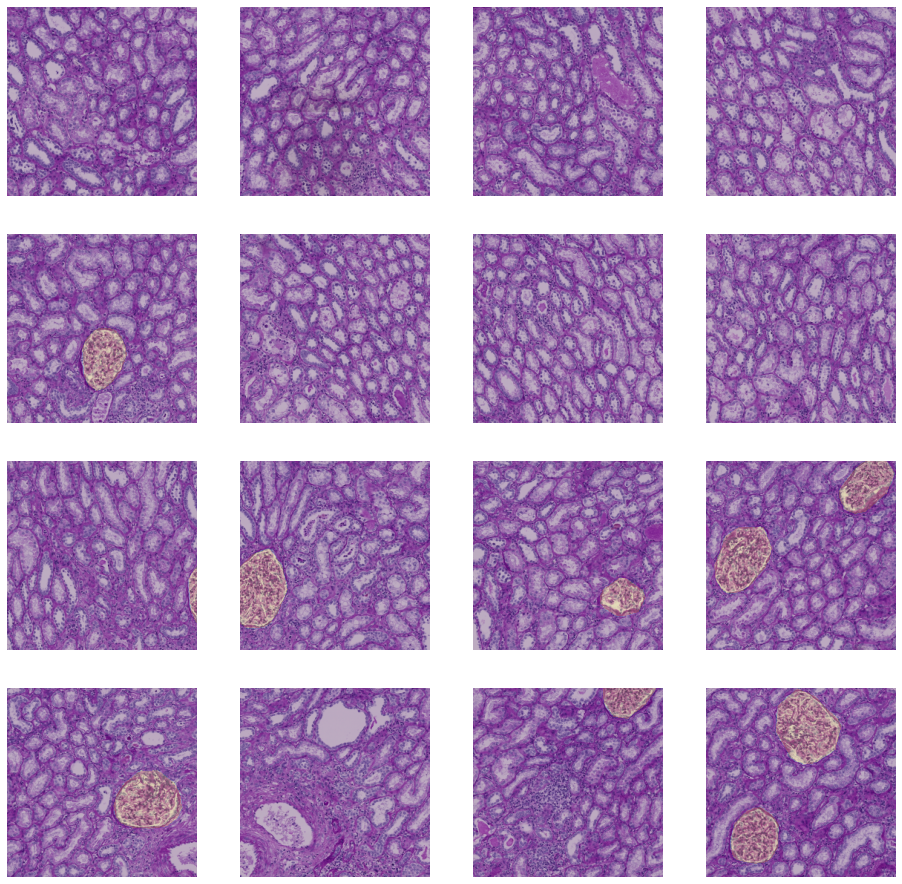

In [6]:
columns, rows = 4,4
idx0 = 20
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

trying to get this working in kaggle: https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter

In [7]:

from fastai import *
from fastai.vision.all import *

In [8]:
import torch

In [9]:
from torch.utils.data import Dataset, DataLoader

In [10]:
import torchvision
from torchvision.transforms import *
from torchvision import *

In [11]:
from albumentations import *
#for all the transforms that he uses

In [12]:
from sklearn.model_selection import *

In [13]:
!unzip ./masks.zip -d ./masks
!unzip ./train.zip -d ./train

Archive:  ./masks.zip
 extracting: ./masks/2f6ecfcdf_63.png  
 extracting: ./masks/2f6ecfcdf_64.png  
 extracting: ./masks/2f6ecfcdf_65.png  
 extracting: ./masks/2f6ecfcdf_66.png  
 extracting: ./masks/2f6ecfcdf_89.png  
 extracting: ./masks/2f6ecfcdf_90.png  
 extracting: ./masks/2f6ecfcdf_91.png  
 extracting: ./masks/2f6ecfcdf_92.png  
 extracting: ./masks/2f6ecfcdf_93.png  
 extracting: ./masks/2f6ecfcdf_114.png  
 extracting: ./masks/2f6ecfcdf_115.png  
 extracting: ./masks/2f6ecfcdf_116.png  
 extracting: ./masks/2f6ecfcdf_117.png  
 extracting: ./masks/2f6ecfcdf_118.png  
 extracting: ./masks/2f6ecfcdf_119.png  
 extracting: ./masks/2f6ecfcdf_120.png  
 extracting: ./masks/2f6ecfcdf_121.png  
 extracting: ./masks/2f6ecfcdf_140.png  
 extracting: ./masks/2f6ecfcdf_141.png  
 extracting: ./masks/2f6ecfcdf_142.png  
 extracting: ./masks/2f6ecfcdf_143.png  
 extracting: ./masks/2f6ecfcdf_144.png  
 extracting: ./masks/2f6ecfcdf_145.png  
 extracting: ./masks/2f6ecfcdf_146.png  
 ex

 extracting: ./masks/cb2d976f4_316.png  
 extracting: ./masks/cb2d976f4_317.png  
 extracting: ./masks/cb2d976f4_318.png  
 extracting: ./masks/cb2d976f4_319.png  
 extracting: ./masks/cb2d976f4_320.png  
 extracting: ./masks/cb2d976f4_321.png  
 extracting: ./masks/cb2d976f4_322.png  
 extracting: ./masks/cb2d976f4_323.png  
 extracting: ./masks/cb2d976f4_324.png  
 extracting: ./masks/cb2d976f4_325.png  
 extracting: ./masks/cb2d976f4_326.png  
 extracting: ./masks/cb2d976f4_327.png  
 extracting: ./masks/cb2d976f4_328.png  
 extracting: ./masks/cb2d976f4_352.png  
 extracting: ./masks/cb2d976f4_353.png  
 extracting: ./masks/cb2d976f4_354.png  
 extracting: ./masks/cb2d976f4_355.png  
 extracting: ./masks/cb2d976f4_358.png  
 extracting: ./masks/cb2d976f4_359.png  
 extracting: ./masks/cb2d976f4_360.png  
 extracting: ./masks/cb2d976f4_363.png  
 extracting: ./masks/cb2d976f4_364.png  
 extracting: ./masks/cb2d976f4_365.png  
 extracting: ./masks/cb2d976f4_366.png  
 extracting: ./m

 extracting: ./masks/cb2d976f4_1333.png  
 extracting: ./masks/cb2d976f4_1334.png  
 extracting: ./masks/cb2d976f4_1335.png  
 extracting: ./masks/cb2d976f4_1336.png  
 extracting: ./masks/cb2d976f4_1337.png  
 extracting: ./masks/cb2d976f4_1338.png  
 extracting: ./masks/cb2d976f4_1339.png  
 extracting: ./masks/cb2d976f4_1340.png  
 extracting: ./masks/cb2d976f4_1341.png  
 extracting: ./masks/cb2d976f4_1342.png  
 extracting: ./masks/cb2d976f4_1343.png  
 extracting: ./masks/cb2d976f4_1344.png  
 extracting: ./masks/cb2d976f4_1345.png  
 extracting: ./masks/cb2d976f4_1346.png  
 extracting: ./masks/cb2d976f4_1347.png  
 extracting: ./masks/cb2d976f4_1348.png  
 extracting: ./masks/cb2d976f4_1349.png  
 extracting: ./masks/cb2d976f4_1350.png  
 extracting: ./masks/cb2d976f4_1351.png  
 extracting: ./masks/cb2d976f4_1352.png  
 extracting: ./masks/cb2d976f4_1353.png  
 extracting: ./masks/cb2d976f4_1354.png  
 extracting: ./masks/cb2d976f4_1355.png  
 extracting: ./masks/cb2d976f4_135

 extracting: ./masks/e79de561c_335.png  
 extracting: ./masks/e79de561c_336.png  
 extracting: ./masks/e79de561c_337.png  
 extracting: ./masks/e79de561c_338.png  
 extracting: ./masks/e79de561c_339.png  
 extracting: ./masks/e79de561c_340.png  
 extracting: ./masks/e79de561c_341.png  
 extracting: ./masks/e79de561c_342.png  
 extracting: ./masks/e79de561c_343.png  
 extracting: ./masks/e79de561c_344.png  
 extracting: ./masks/e79de561c_345.png  
 extracting: ./masks/e79de561c_346.png  
 extracting: ./masks/e79de561c_347.png  
 extracting: ./masks/e79de561c_348.png  
 extracting: ./masks/e79de561c_352.png  
 extracting: ./masks/e79de561c_353.png  
 extracting: ./masks/e79de561c_354.png  
 extracting: ./masks/e79de561c_355.png  
 extracting: ./masks/e79de561c_356.png  
 extracting: ./masks/e79de561c_357.png  
 extracting: ./masks/e79de561c_358.png  
 extracting: ./masks/e79de561c_359.png  
 extracting: ./masks/e79de561c_360.png  
 extracting: ./masks/e79de561c_361.png  
 extracting: ./m

 extracting: ./masks/095bf7a1f_1233.png  
 extracting: ./masks/095bf7a1f_1234.png  
 extracting: ./masks/095bf7a1f_1235.png  
 extracting: ./masks/095bf7a1f_1236.png  
 extracting: ./masks/095bf7a1f_1237.png  
 extracting: ./masks/095bf7a1f_1238.png  
 extracting: ./masks/095bf7a1f_1239.png  
 extracting: ./masks/095bf7a1f_1240.png  
 extracting: ./masks/095bf7a1f_1241.png  
 extracting: ./masks/095bf7a1f_1264.png  
 extracting: ./masks/095bf7a1f_1266.png  
 extracting: ./masks/095bf7a1f_1267.png  
 extracting: ./masks/095bf7a1f_1268.png  
 extracting: ./masks/095bf7a1f_1269.png  
 extracting: ./masks/095bf7a1f_1270.png  
 extracting: ./masks/095bf7a1f_1271.png  
 extracting: ./masks/095bf7a1f_1272.png  
 extracting: ./masks/095bf7a1f_1273.png  
 extracting: ./masks/095bf7a1f_1274.png  
 extracting: ./masks/095bf7a1f_1275.png  
 extracting: ./masks/095bf7a1f_1276.png  
 extracting: ./masks/095bf7a1f_1277.png  
 extracting: ./masks/095bf7a1f_1278.png  
 extracting: ./masks/095bf7a1f_127

 extracting: ./masks/1e2425f28_571.png  
 extracting: ./masks/1e2425f28_572.png  
 extracting: ./masks/1e2425f28_573.png  
 extracting: ./masks/1e2425f28_574.png  
 extracting: ./masks/1e2425f28_575.png  
 extracting: ./masks/1e2425f28_577.png  
 extracting: ./masks/1e2425f28_578.png  
 extracting: ./masks/1e2425f28_579.png  
 extracting: ./masks/1e2425f28_580.png  
 extracting: ./masks/1e2425f28_581.png  
 extracting: ./masks/1e2425f28_582.png  
 extracting: ./masks/1e2425f28_583.png  
 extracting: ./masks/1e2425f28_584.png  
 extracting: ./masks/1e2425f28_585.png  
 extracting: ./masks/1e2425f28_586.png  
 extracting: ./masks/1e2425f28_587.png  
 extracting: ./masks/1e2425f28_588.png  
 extracting: ./masks/1e2425f28_589.png  
 extracting: ./masks/1e2425f28_590.png  
 extracting: ./masks/1e2425f28_591.png  
 extracting: ./masks/1e2425f28_592.png  
 extracting: ./masks/1e2425f28_593.png  
 extracting: ./masks/1e2425f28_594.png  
 extracting: ./masks/1e2425f28_595.png  
 extracting: ./m

 extracting: ./train/2f6ecfcdf_243.png  
 extracting: ./train/2f6ecfcdf_244.png  
 extracting: ./train/2f6ecfcdf_245.png  
 extracting: ./train/2f6ecfcdf_246.png  
 extracting: ./train/2f6ecfcdf_247.png  
 extracting: ./train/2f6ecfcdf_248.png  
 extracting: ./train/2f6ecfcdf_249.png  
 extracting: ./train/2f6ecfcdf_250.png  
 extracting: ./train/2f6ecfcdf_251.png  
 extracting: ./train/2f6ecfcdf_252.png  
 extracting: ./train/2f6ecfcdf_253.png  
 extracting: ./train/2f6ecfcdf_254.png  
 extracting: ./train/2f6ecfcdf_255.png  
 extracting: ./train/2f6ecfcdf_268.png  
 extracting: ./train/2f6ecfcdf_269.png  
 extracting: ./train/2f6ecfcdf_270.png  
 extracting: ./train/2f6ecfcdf_271.png  
 extracting: ./train/2f6ecfcdf_272.png  
 extracting: ./train/2f6ecfcdf_273.png  
 extracting: ./train/2f6ecfcdf_274.png  
 extracting: ./train/2f6ecfcdf_275.png  
 extracting: ./train/2f6ecfcdf_276.png  
 extracting: ./train/2f6ecfcdf_277.png  
 extracting: ./train/2f6ecfcdf_278.png  
 extracting: ./t

 extracting: ./train/2f6ecfcdf_590.png  
 extracting: ./train/2f6ecfcdf_591.png  
 extracting: ./train/2f6ecfcdf_592.png  
 extracting: ./train/2f6ecfcdf_606.png  
 extracting: ./train/2f6ecfcdf_607.png  
 extracting: ./train/2f6ecfcdf_608.png  
 extracting: ./train/2f6ecfcdf_609.png  
 extracting: ./train/2f6ecfcdf_610.png  
 extracting: ./train/2f6ecfcdf_611.png  
 extracting: ./train/2f6ecfcdf_612.png  
 extracting: ./train/2f6ecfcdf_613.png  
 extracting: ./train/2f6ecfcdf_614.png  
 extracting: ./train/2f6ecfcdf_615.png  
 extracting: ./train/2f6ecfcdf_616.png  
 extracting: ./train/2f6ecfcdf_617.png  
 extracting: ./train/2f6ecfcdf_618.png  
 extracting: ./train/2f6ecfcdf_634.png  
 extracting: ./train/2f6ecfcdf_635.png  
 extracting: ./train/2f6ecfcdf_637.png  
 extracting: ./train/2f6ecfcdf_638.png  
 extracting: ./train/2f6ecfcdf_639.png  
 extracting: ./train/2f6ecfcdf_640.png  
 extracting: ./train/2f6ecfcdf_641.png  
 extracting: ./train/2f6ecfcdf_642.png  
 extracting: ./t

 extracting: ./train/cb2d976f4_400.png  
 extracting: ./train/cb2d976f4_401.png  
 extracting: ./train/cb2d976f4_402.png  
 extracting: ./train/cb2d976f4_403.png  
 extracting: ./train/cb2d976f4_404.png  
 extracting: ./train/cb2d976f4_406.png  
 extracting: ./train/cb2d976f4_407.png  
 extracting: ./train/cb2d976f4_408.png  
 extracting: ./train/cb2d976f4_409.png  
 extracting: ./train/cb2d976f4_410.png  
 extracting: ./train/cb2d976f4_411.png  
 extracting: ./train/cb2d976f4_412.png  
 extracting: ./train/cb2d976f4_413.png  
 extracting: ./train/cb2d976f4_414.png  
 extracting: ./train/cb2d976f4_415.png  
 extracting: ./train/cb2d976f4_416.png  
 extracting: ./train/cb2d976f4_417.png  
 extracting: ./train/cb2d976f4_418.png  
 extracting: ./train/cb2d976f4_419.png  
 extracting: ./train/cb2d976f4_420.png  
 extracting: ./train/cb2d976f4_421.png  
 extracting: ./train/cb2d976f4_422.png  
 extracting: ./train/cb2d976f4_423.png  
 extracting: ./train/cb2d976f4_424.png  
 extracting: ./t

 extracting: ./train/cb2d976f4_725.png  
 extracting: ./train/cb2d976f4_726.png  
 extracting: ./train/cb2d976f4_727.png  
 extracting: ./train/cb2d976f4_738.png  
 extracting: ./train/cb2d976f4_739.png  
 extracting: ./train/cb2d976f4_740.png  
 extracting: ./train/cb2d976f4_741.png  
 extracting: ./train/cb2d976f4_742.png  
 extracting: ./train/cb2d976f4_743.png  
 extracting: ./train/cb2d976f4_744.png  
 extracting: ./train/cb2d976f4_745.png  
 extracting: ./train/cb2d976f4_746.png  
 extracting: ./train/cb2d976f4_747.png  
 extracting: ./train/cb2d976f4_748.png  
 extracting: ./train/cb2d976f4_749.png  
 extracting: ./train/cb2d976f4_750.png  
 extracting: ./train/cb2d976f4_751.png  
 extracting: ./train/cb2d976f4_752.png  
 extracting: ./train/cb2d976f4_753.png  
 extracting: ./train/cb2d976f4_754.png  
 extracting: ./train/cb2d976f4_755.png  
 extracting: ./train/cb2d976f4_756.png  
 extracting: ./train/cb2d976f4_757.png  
 extracting: ./train/cb2d976f4_758.png  
 extracting: ./t

 extracting: ./train/cb2d976f4_993.png  
 extracting: ./train/cb2d976f4_994.png  
 extracting: ./train/cb2d976f4_995.png  
 extracting: ./train/cb2d976f4_996.png  
 extracting: ./train/cb2d976f4_997.png  
 extracting: ./train/cb2d976f4_998.png  
 extracting: ./train/cb2d976f4_999.png  
 extracting: ./train/cb2d976f4_1000.png  
 extracting: ./train/cb2d976f4_1001.png  
 extracting: ./train/cb2d976f4_1002.png  
 extracting: ./train/cb2d976f4_1003.png  
 extracting: ./train/cb2d976f4_1004.png  
 extracting: ./train/cb2d976f4_1005.png  
 extracting: ./train/cb2d976f4_1006.png  
 extracting: ./train/cb2d976f4_1007.png  
 extracting: ./train/cb2d976f4_1008.png  
 extracting: ./train/cb2d976f4_1009.png  
 extracting: ./train/cb2d976f4_1010.png  
 extracting: ./train/cb2d976f4_1011.png  
 extracting: ./train/cb2d976f4_1012.png  
 extracting: ./train/cb2d976f4_1013.png  
 extracting: ./train/cb2d976f4_1014.png  
 extracting: ./train/cb2d976f4_1015.png  
 extracting: ./train/cb2d976f4_1016.png  

 extracting: ./train/cb2d976f4_1247.png  
 extracting: ./train/cb2d976f4_1248.png  
 extracting: ./train/cb2d976f4_1249.png  
 extracting: ./train/cb2d976f4_1250.png  
 extracting: ./train/cb2d976f4_1251.png  
 extracting: ./train/cb2d976f4_1252.png  
 extracting: ./train/cb2d976f4_1253.png  
 extracting: ./train/cb2d976f4_1254.png  
 extracting: ./train/cb2d976f4_1255.png  
 extracting: ./train/cb2d976f4_1256.png  
 extracting: ./train/cb2d976f4_1257.png  
 extracting: ./train/cb2d976f4_1258.png  
 extracting: ./train/cb2d976f4_1259.png  
 extracting: ./train/cb2d976f4_1260.png  
 extracting: ./train/cb2d976f4_1261.png  
 extracting: ./train/cb2d976f4_1262.png  
 extracting: ./train/cb2d976f4_1263.png  
 extracting: ./train/cb2d976f4_1264.png  
 extracting: ./train/cb2d976f4_1267.png  
 extracting: ./train/cb2d976f4_1268.png  
 extracting: ./train/cb2d976f4_1269.png  
 extracting: ./train/cb2d976f4_1270.png  
 extracting: ./train/cb2d976f4_1271.png  
 extracting: ./train/cb2d976f4_127

 extracting: ./train/0486052bb_150.png  
 extracting: ./train/0486052bb_151.png  
 extracting: ./train/0486052bb_152.png  
 extracting: ./train/0486052bb_153.png  
 extracting: ./train/0486052bb_154.png  
 extracting: ./train/0486052bb_155.png  
 extracting: ./train/0486052bb_156.png  
 extracting: ./train/0486052bb_157.png  
 extracting: ./train/0486052bb_158.png  
 extracting: ./train/0486052bb_159.png  
 extracting: ./train/0486052bb_160.png  
 extracting: ./train/0486052bb_161.png  
 extracting: ./train/0486052bb_162.png  
 extracting: ./train/0486052bb_163.png  
 extracting: ./train/0486052bb_164.png  
 extracting: ./train/0486052bb_165.png  
 extracting: ./train/0486052bb_166.png  
 extracting: ./train/0486052bb_167.png  
 extracting: ./train/0486052bb_168.png  
 extracting: ./train/0486052bb_169.png  
 extracting: ./train/0486052bb_170.png  
 extracting: ./train/0486052bb_182.png  
 extracting: ./train/0486052bb_183.png  
 extracting: ./train/0486052bb_184.png  
 extracting: ./t

 extracting: ./train/0486052bb_535.png  
 extracting: ./train/0486052bb_536.png  
 extracting: ./train/0486052bb_537.png  
 extracting: ./train/0486052bb_538.png  
 extracting: ./train/0486052bb_539.png  
 extracting: ./train/0486052bb_540.png  
 extracting: ./train/0486052bb_541.png  
 extracting: ./train/0486052bb_542.png  
 extracting: ./train/0486052bb_543.png  
 extracting: ./train/0486052bb_544.png  
 extracting: ./train/0486052bb_545.png  
 extracting: ./train/0486052bb_566.png  
 extracting: ./train/0486052bb_567.png  
 extracting: ./train/0486052bb_568.png  
 extracting: ./train/0486052bb_569.png  
 extracting: ./train/0486052bb_570.png  
 extracting: ./train/0486052bb_571.png  
 extracting: ./train/0486052bb_572.png  
 extracting: ./train/0486052bb_573.png  
 extracting: ./train/0486052bb_574.png  
 extracting: ./train/0486052bb_575.png  
 extracting: ./train/0486052bb_576.png  
 extracting: ./train/0486052bb_577.png  
 extracting: ./train/0486052bb_578.png  
 extracting: ./t

 extracting: ./train/e79de561c_204.png  
 extracting: ./train/e79de561c_205.png  
 extracting: ./train/e79de561c_206.png  
 extracting: ./train/e79de561c_207.png  
 extracting: ./train/e79de561c_208.png  
 extracting: ./train/e79de561c_209.png  
 extracting: ./train/e79de561c_210.png  
 extracting: ./train/e79de561c_211.png  
 extracting: ./train/e79de561c_212.png  
 extracting: ./train/e79de561c_213.png  
 extracting: ./train/e79de561c_214.png  
 extracting: ./train/e79de561c_215.png  
 extracting: ./train/e79de561c_216.png  
 extracting: ./train/e79de561c_217.png  
 extracting: ./train/e79de561c_218.png  
 extracting: ./train/e79de561c_219.png  
 extracting: ./train/e79de561c_220.png  
 extracting: ./train/e79de561c_221.png  
 extracting: ./train/e79de561c_222.png  
 extracting: ./train/e79de561c_223.png  
 extracting: ./train/e79de561c_224.png  
 extracting: ./train/e79de561c_225.png  
 extracting: ./train/e79de561c_226.png  
 extracting: ./train/e79de561c_227.png  
 extracting: ./t

 extracting: ./train/095bf7a1f_294.png  
 extracting: ./train/095bf7a1f_295.png  
 extracting: ./train/095bf7a1f_296.png  
 extracting: ./train/095bf7a1f_297.png  
 extracting: ./train/095bf7a1f_320.png  
 extracting: ./train/095bf7a1f_321.png  
 extracting: ./train/095bf7a1f_322.png  
 extracting: ./train/095bf7a1f_323.png  
 extracting: ./train/095bf7a1f_324.png  
 extracting: ./train/095bf7a1f_325.png  
 extracting: ./train/095bf7a1f_326.png  
 extracting: ./train/095bf7a1f_327.png  
 extracting: ./train/095bf7a1f_328.png  
 extracting: ./train/095bf7a1f_329.png  
 extracting: ./train/095bf7a1f_330.png  
 extracting: ./train/095bf7a1f_331.png  
 extracting: ./train/095bf7a1f_332.png  
 extracting: ./train/095bf7a1f_333.png  
 extracting: ./train/095bf7a1f_334.png  
 extracting: ./train/095bf7a1f_335.png  
 extracting: ./train/095bf7a1f_336.png  
 extracting: ./train/095bf7a1f_359.png  
 extracting: ./train/095bf7a1f_360.png  
 extracting: ./train/095bf7a1f_361.png  
 extracting: ./t

 extracting: ./train/095bf7a1f_726.png  
 extracting: ./train/095bf7a1f_727.png  
 extracting: ./train/095bf7a1f_728.png  
 extracting: ./train/095bf7a1f_729.png  
 extracting: ./train/095bf7a1f_730.png  
 extracting: ./train/095bf7a1f_731.png  
 extracting: ./train/095bf7a1f_743.png  
 extracting: ./train/095bf7a1f_744.png  
 extracting: ./train/095bf7a1f_745.png  
 extracting: ./train/095bf7a1f_746.png  
 extracting: ./train/095bf7a1f_747.png  
 extracting: ./train/095bf7a1f_748.png  
 extracting: ./train/095bf7a1f_749.png  
 extracting: ./train/095bf7a1f_750.png  
 extracting: ./train/095bf7a1f_751.png  
 extracting: ./train/095bf7a1f_752.png  
 extracting: ./train/095bf7a1f_753.png  
 extracting: ./train/095bf7a1f_754.png  
 extracting: ./train/095bf7a1f_755.png  
 extracting: ./train/095bf7a1f_756.png  
 extracting: ./train/095bf7a1f_757.png  
 extracting: ./train/095bf7a1f_758.png  
 extracting: ./train/095bf7a1f_759.png  
 extracting: ./train/095bf7a1f_760.png  
 extracting: ./t

 extracting: ./train/095bf7a1f_1042.png  
 extracting: ./train/095bf7a1f_1043.png  
 extracting: ./train/095bf7a1f_1044.png  
 extracting: ./train/095bf7a1f_1053.png  
 extracting: ./train/095bf7a1f_1057.png  
 extracting: ./train/095bf7a1f_1058.png  
 extracting: ./train/095bf7a1f_1059.png  
 extracting: ./train/095bf7a1f_1060.png  
 extracting: ./train/095bf7a1f_1061.png  
 extracting: ./train/095bf7a1f_1062.png  
 extracting: ./train/095bf7a1f_1063.png  
 extracting: ./train/095bf7a1f_1064.png  
 extracting: ./train/095bf7a1f_1065.png  
 extracting: ./train/095bf7a1f_1066.png  
 extracting: ./train/095bf7a1f_1067.png  
 extracting: ./train/095bf7a1f_1068.png  
 extracting: ./train/095bf7a1f_1069.png  
 extracting: ./train/095bf7a1f_1070.png  
 extracting: ./train/095bf7a1f_1071.png  
 extracting: ./train/095bf7a1f_1072.png  
 extracting: ./train/095bf7a1f_1073.png  
 extracting: ./train/095bf7a1f_1074.png  
 extracting: ./train/095bf7a1f_1075.png  
 extracting: ./train/095bf7a1f_107

 extracting: ./train/54f2eec69_124.png  
 extracting: ./train/54f2eec69_125.png  
 extracting: ./train/54f2eec69_126.png  
 extracting: ./train/54f2eec69_127.png  
 extracting: ./train/54f2eec69_128.png  
 extracting: ./train/54f2eec69_137.png  
 extracting: ./train/54f2eec69_138.png  
 extracting: ./train/54f2eec69_139.png  
 extracting: ./train/54f2eec69_140.png  
 extracting: ./train/54f2eec69_141.png  
 extracting: ./train/54f2eec69_142.png  
 extracting: ./train/54f2eec69_143.png  
 extracting: ./train/54f2eec69_144.png  
 extracting: ./train/54f2eec69_145.png  
 extracting: ./train/54f2eec69_146.png  
 extracting: ./train/54f2eec69_147.png  
 extracting: ./train/54f2eec69_148.png  
 extracting: ./train/54f2eec69_149.png  
 extracting: ./train/54f2eec69_150.png  
 extracting: ./train/54f2eec69_151.png  
 extracting: ./train/54f2eec69_159.png  
 extracting: ./train/54f2eec69_160.png  
 extracting: ./train/54f2eec69_161.png  
 extracting: ./train/54f2eec69_162.png  
 extracting: ./t

 extracting: ./train/54f2eec69_387.png  
 extracting: ./train/54f2eec69_388.png  
 extracting: ./train/54f2eec69_389.png  
 extracting: ./train/54f2eec69_398.png  
 extracting: ./train/54f2eec69_399.png  
 extracting: ./train/54f2eec69_400.png  
 extracting: ./train/54f2eec69_401.png  
 extracting: ./train/54f2eec69_402.png  
 extracting: ./train/54f2eec69_403.png  
 extracting: ./train/54f2eec69_404.png  
 extracting: ./train/54f2eec69_405.png  
 extracting: ./train/54f2eec69_406.png  
 extracting: ./train/54f2eec69_407.png  
 extracting: ./train/54f2eec69_408.png  
 extracting: ./train/54f2eec69_409.png  
 extracting: ./train/54f2eec69_410.png  
 extracting: ./train/54f2eec69_420.png  
 extracting: ./train/54f2eec69_421.png  
 extracting: ./train/54f2eec69_422.png  
 extracting: ./train/54f2eec69_423.png  
 extracting: ./train/54f2eec69_424.png  
 extracting: ./train/54f2eec69_425.png  
 extracting: ./train/54f2eec69_426.png  
 extracting: ./train/54f2eec69_427.png  
 extracting: ./t

 extracting: ./train/1e2425f28_281.png  
 extracting: ./train/1e2425f28_282.png  
 extracting: ./train/1e2425f28_283.png  
 extracting: ./train/1e2425f28_284.png  
 extracting: ./train/1e2425f28_285.png  
 extracting: ./train/1e2425f28_292.png  
 extracting: ./train/1e2425f28_293.png  
 extracting: ./train/1e2425f28_294.png  
 extracting: ./train/1e2425f28_295.png  
 extracting: ./train/1e2425f28_296.png  
 extracting: ./train/1e2425f28_297.png  
 extracting: ./train/1e2425f28_298.png  
 extracting: ./train/1e2425f28_299.png  
 extracting: ./train/1e2425f28_300.png  
 extracting: ./train/1e2425f28_301.png  
 extracting: ./train/1e2425f28_302.png  
 extracting: ./train/1e2425f28_303.png  
 extracting: ./train/1e2425f28_304.png  
 extracting: ./train/1e2425f28_305.png  
 extracting: ./train/1e2425f28_306.png  
 extracting: ./train/1e2425f28_307.png  
 extracting: ./train/1e2425f28_308.png  
 extracting: ./train/1e2425f28_309.png  
 extracting: ./train/1e2425f28_310.png  
 extracting: ./t

 extracting: ./train/1e2425f28_543.png  
 extracting: ./train/1e2425f28_545.png  
 extracting: ./train/1e2425f28_546.png  
 extracting: ./train/1e2425f28_547.png  
 extracting: ./train/1e2425f28_548.png  
 extracting: ./train/1e2425f28_549.png  
 extracting: ./train/1e2425f28_550.png  
 extracting: ./train/1e2425f28_551.png  
 extracting: ./train/1e2425f28_552.png  
 extracting: ./train/1e2425f28_553.png  
 extracting: ./train/1e2425f28_554.png  
 extracting: ./train/1e2425f28_555.png  
 extracting: ./train/1e2425f28_556.png  
 extracting: ./train/1e2425f28_557.png  
 extracting: ./train/1e2425f28_558.png  
 extracting: ./train/1e2425f28_559.png  
 extracting: ./train/1e2425f28_560.png  
 extracting: ./train/1e2425f28_561.png  
 extracting: ./train/1e2425f28_562.png  
 extracting: ./train/1e2425f28_563.png  
 extracting: ./train/1e2425f28_564.png  
 extracting: ./train/1e2425f28_565.png  
 extracting: ./train/1e2425f28_566.png  
 extracting: ./train/1e2425f28_567.png  
 extracting: ./t

In [14]:
bs = 64
nfolds = 4
fold = 0
SEED = 2020
TRAIN = './train/'
MASKS = './masks/'
LABELS = '../input/hubmap-kidney-segmentation/train.csv'
NUM_WORKERS = 4

In [15]:
# https://www.kaggle.com/iafoss/256x256-images
mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

In [16]:
def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPDataset(Dataset):
    def __init__(self, fold=fold, train=True, tfms=None):
        ids = pd.read_csv(LABELS).id.values
        kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        self.fnames = [fname for fname in os.listdir(TRAIN) if fname.split('_')[0] in ids]
        self.train = train
        self.tfms = tfms
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.cvtColor(cv2.imread(os.path.join(TRAIN,fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASKS,fname),cv2.IMREAD_GRAYSCALE)
        if self.tfms is not None:
            augmented = self.tfms(image=img,mask=mask)
            img,mask = augmented['image'],augmented['mask']
        return img2tensor((img/255.0 - mean)/std),img2tensor(mask)
    
def get_aug(p=1.0):
    return Compose([
        HorizontalFlip(),
        VerticalFlip(),
        RandomRotate90(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            HueSaturationValue(10,15,10),
            CLAHE(clip_limit=2),
            RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)

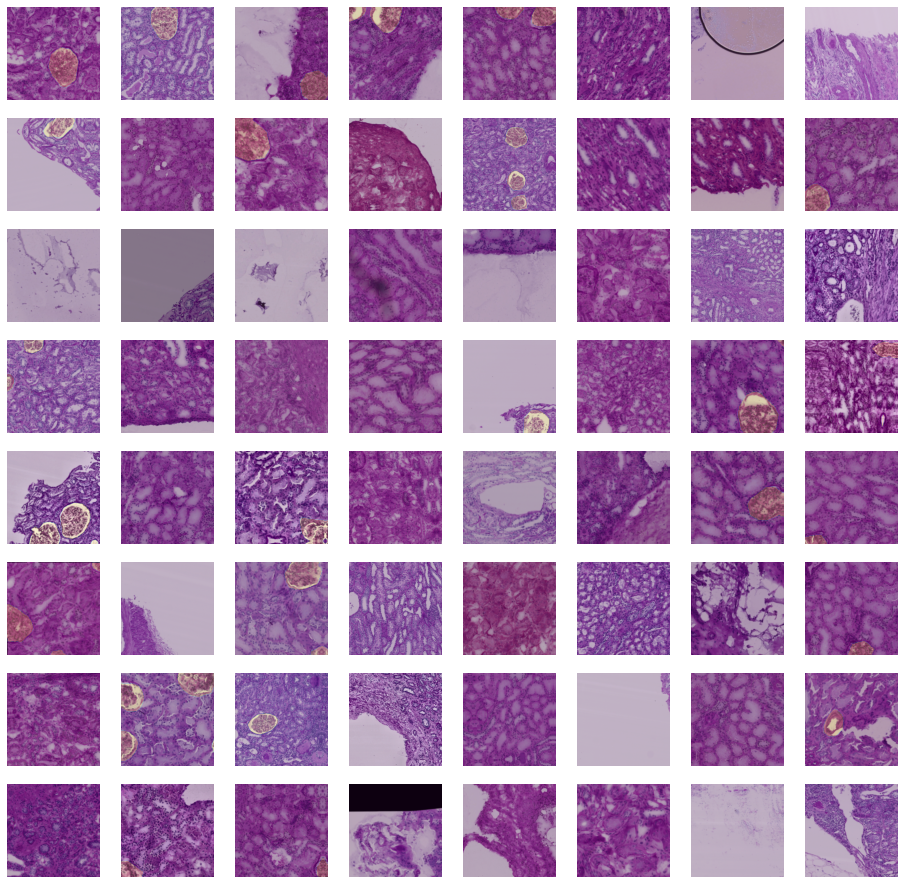

In [17]:
#example of train images with masks
ds = HuBMAPDataset(tfms=get_aug())
dl = DataLoader(ds,batch_size=64,shuffle=False,num_workers=NUM_WORKERS)
imgs,masks = next(iter(dl))

plt.figure(figsize=(16,16))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*std + mean)*255.0).numpy().astype(np.uint8)
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
del ds,dl,imgs,masks

In [18]:
class UneXt50(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
        m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
                           'resnext50_32x4d_ssl')
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x

#split the model to encoder and decoder for fast.ai
split_layers = lambda m: [list(m.enc0.parameters())+list(m.enc1.parameters())+
                list(m.enc2.parameters())+list(m.enc3.parameters())+
                list(m.enc4.parameters()),
                list(m.aspp.parameters())+list(m.dec4.parameters())+
                list(m.dec3.parameters())+list(m.dec2.parameters())+
                list(m.dec1.parameters())+list(m.fpn.parameters())+
                list(m.final_conv.parameters())]

In [19]:
def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1.0 - targets))

In [20]:
class Dice_soft(Metric):
    def __init__(self, axis=1): 
        self.axis = axis 
    def reset(self): self.inter,self.union = 0,0
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        self.inter += (pred*targ).float().sum().item()
        self.union += (pred+targ).float().sum().item()
    @property
    def value(self): return 2.0 * self.inter/self.union if self.union > 0 else None
    
# dice with automatic threshold selection
class Dice_th(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.05), axis=1): 
        self.axis = axis
        self.ths = ths
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self, learn):
        pred,targ = flatten_check(torch.sigmoid(learn.pred), learn.y)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 
                2.0*self.inter/self.union, torch.zeros_like(self.union))
        return dices.max()

In [21]:
#iterator like wrapper that returns predicted and gt masks
class Model_pred:
    def __init__(self, model, dl, tta:bool=True, half:bool=False):
        self.model = model
        self.dl = dl
        self.tta = tta
        self.half = half
        
    def __iter__(self):
        self.model.eval()
        name_list = self.dl.dataset.fnames
        count=0
        with torch.no_grad():
            for x,y in iter(self.dl):
                x = x.cuda()
                if self.half: x = x.half()
                p = self.model(x)
                py = torch.sigmoid(p).detach()
                if self.tta:
                    #x,y,xy flips as TTA
                    flips = [[-1],[-2],[-2,-1]]
                    for f in flips:
                        p = self.model(torch.flip(x,f))
                        p = torch.flip(p,f)
                        py += torch.sigmoid(p).detach()
                    py /= (1+len(flips))
                if y is not None and len(y.shape)==4 and py.shape != y.shape:
                    py = F.upsample(py, size=(y.shape[-2],y.shape[-1]), mode="bilinear")
                py = py.permute(0,2,3,1).float().cpu()
                batch_size = len(py)
                for i in range(batch_size):
                    taget = y[i].detach().cpu() if y is not None else None
                    yield py[i],taget,name_list[count]
                    count += 1
                    
    def __len__(self):
        return len(self.dl.dataset)
    
class Dice_th_pred(Metric):
    def __init__(self, ths=np.arange(0.1,0.9,0.01), axis=1): 
        self.axis = axis
        self.ths = ths
        self.reset()
        
    def reset(self): 
        self.inter = torch.zeros(len(self.ths))
        self.union = torch.zeros(len(self.ths))
        
    def accumulate(self,p,t):
        pred,targ = flatten_check(p, t)
        for i,th in enumerate(self.ths):
            p = (pred > th).float()
            self.inter[i] += (p*targ).float().sum().item()
            self.union[i] += (p+targ).float().sum().item()

    @property
    def value(self):
        dices = torch.where(self.union > 0.0, 2.0*self.inter/self.union, 
                            torch.zeros_like(self.union))
        return dices
    
def save_img(data,name,out):
    data = data.float().cpu().numpy()
    img = cv2.imencode('.png',(data*255).astype(np.uint8))[1]
    out.writestr(name, img)

In [22]:
dice = Dice_th_pred(np.arange(0.2,0.7,0.01))
for fold in range(nfolds):
    ds_t = HuBMAPDataset(fold=fold, train=True, tfms=get_aug())
    ds_v = HuBMAPDataset(fold=fold, train=False)
    data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=bs,
                num_workers=NUM_WORKERS,pin_memory=True).cuda()
    model = UneXt50().cuda()
    learn = Learner(data, model, loss_func=symmetric_lovasz,
                metrics=[Dice_soft(),Dice_th()], 
                splitter=split_layers).to_fp16(clip=0.5)
    
    #start with training the head
    learn.freeze_to(-1) #doesn't work
    for param in learn.opt.param_groups[0]['params']:
        param.requires_grad = False
    learn.fit_one_cycle(6, lr_max=0.5e-2)

    #continue training full model
    learn.unfreeze()
    learn.fit_one_cycle(32, lr_max=slice(2e-4,2e-3),
        cbs=SaveModelCallback(monitor='dice_th',comp=np.greater))
    torch.save(learn.model.state_dict(),f'model_{fold}.pth')
    
    #model evaluation on val and saving the masks
    mp = Model_pred(learn.model,learn.dls.loaders[1])
    with zipfile.ZipFile('val_masks_tta.zip', 'a') as out:
        for p in progress_bar(mp):
            dice.accumulate(p[0],p[1])
            save_img(p[0],p[2],out)
    gc.collect()
    
dices = dice.value
noise_ths = dice.ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()

Downloading: "https://github.com/facebookresearch/semi-supervised-ImageNet1K-models/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://dl.fbaipublicfiles.com/semiweaksupervision/model_files/semi_supervised_resnext50_32x4-ddb3e555.pth" to /root/.cache/torch/hub/checkpoints/semi_supervised_resnext50_32x4-ddb3e555.pth


NameError: name 'ASPP' is not defined

finally from here : https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter-sub

In [ ]:
sz = 256   #the size of tiles
reduce = 4 #reduce the original images by 4 times
TH = 0.39  #threshold for positive predictions
DATA = '../input/hubmap-kidney-segmentation/test/'
MODELS = [f'../input/hubmap-fast-ai-starter/model_{i}.pth' for i in range(4)]
df_sample = pd.read_csv('../input/hubmap-kidney-segmentation/sample_submission.csv')
bs = 64
NUM_WORKERS = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn

In [ ]:
# https://www.kaggle.com/iafoss/256x256-images
mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class HuBMAPTestDataset(Dataset):
    def __init__(self, imgs, idxs):
        self.imgs = imgs
        self.fnames = idxs
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        return img2tensor((self.imgs[idx]/255.0 - mean)/std)

In [ ]:
#iterator like wrapper that returns predicted masks
class Model_pred:
    def __init__(self, models, dl, tta:bool=True, half:bool=False):
        self.models = models
        self.dl = dl
        self.tta = tta
        self.half = half
        
    def __iter__(self):
        count=0
        with torch.no_grad():
            for x in iter(self.dl):
                x = x.to(device)
                if self.half: x = x.half()
                py = None
                for model in self.models:
                    p = model(x)
                    p = torch.sigmoid(p).detach()
                    if py is None: py = p
                    else: py += p
                if self.tta:
                    #x,y,xy flips as TTA
                    flips = [[-1],[-2],[-2,-1]]
                    for f in flips:
                        xf = torch.flip(x,f)
                        for model in self.models:
                            p = model(xf)
                            p = torch.flip(p,f)
                            py += torch.sigmoid(p).detach()
                    py /= (1+len(flips))        
                py /= len(self.models)
                    
                py = F.upsample(py, scale_factor=reduce, mode="bilinear")
                py = py.permute(0,2,3,1).float().cpu()
                batch_size = len(py)
                for i in range(batch_size):
                    yield py[i]
                    count += 1
                    
    def __len__(self):
        return len(self.dl.dataset)

In [ ]:
from torchvision.models.resnet import ResNet, Bottleneck
class UneXt50(nn.Module):
    def __init__(self, stride=1, **kwargs):
        super().__init__()
        #encoder
        m = ResNet(Bottleneck, [3, 4, 6, 3], groups=32, width_per_group=4)
        #m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models',
        #                   'resnext50_32x4d_ssl')
        self.enc0 = nn.Sequential(m.conv1, m.bn1, nn.ReLU(inplace=True))
        self.enc1 = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1),
                            m.layer1) #256
        self.enc2 = m.layer2 #512
        self.enc3 = m.layer3 #1024
        self.enc4 = m.layer4 #2048
        #aspp with customized dilatations
        self.aspp = ASPP(2048,256,out_c=512,dilations=[stride*1,stride*2,stride*3,stride*4])
        self.drop_aspp = nn.Dropout2d(0.5)
        #decoder
        self.dec4 = UnetBlock(512,1024,256)
        self.dec3 = UnetBlock(256,512,128)
        self.dec2 = UnetBlock(128,256,64)
        self.dec1 = UnetBlock(64,64,32)
        self.fpn = FPN([512,256,128,64],[16]*4)
        self.drop = nn.Dropout2d(0.1)
        self.final_conv = ConvLayer(32+16*4, 1, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        enc0 = self.enc0(x)
        enc1 = self.enc1(enc0)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.aspp(enc4)
        dec3 = self.dec4(self.drop_aspp(enc5),enc3)
        dec2 = self.dec3(dec3,enc2)
        dec1 = self.dec2(dec2,enc1)
        dec0 = self.dec1(dec1,enc0)
        x = self.fpn([enc5, dec3, dec2, dec1], dec0)
        x = self.final_conv(self.drop(x))
        x = F.interpolate(x,scale_factor=2,mode='bilinear')
        return x

In [ ]:
models = []
for path in MODELS:
    state_dict = torch.load(path,map_location=torch.device('cpu'))
    model = UneXt50()
    model.load_state_dict(state_dict)
    model.float()
    model.eval()
    model.to(device)
    models.append(model)

del state_dict

In [ ]:
#Somehow I cannot resolve the submission error with consideration of the
#private LB data, and the submission error doesn't give an informative
#output. So, for now I share the notbook that makes a submission only
#to the public LB, and later I'll try to resolve the issue.
#IMPORTANT: This notebook doesn't perform predictions for the private LB.
names,preds = [],[]
samples = ['b9a3865fc','b2dc8411c','26dc41664','c68fe75ea','afa5e8098']
samples_n = [id for id in df_sample.id if id not in samples]

names += samples_n
preds += [np.NaN]*len(samples_n)
df_sample = df_sample.loc[df_sample.id.isin(samples)]

In [ ]:
#https://www.kaggle.com/iafoss/256x256-images
s_th = 40  #saturation blancking threshold
p_th = 200*sz//256 #threshold for the minimum number of pixels
#names,preds = [],[]
for idx,row in tqdm(df_sample.iterrows(),total=len(df_sample)):
    idx = row['id']
    #read image
    img = tiff.imread(os.path.join(DATA,idx+'.tiff'))
    if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1,2,0))
    
    #add padding to make the image dividable into tiles
    img_shape = img.shape
    pad0 = (reduce*sz - img_shape[0]%(reduce*sz))%(reduce*sz)
    pad1 = (reduce*sz - img_shape[1]%(reduce*sz))%(reduce*sz)
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=0)

    #split image into tiles using the reshape+transpose trick
    if reduce != 1:
        img = cv2.resize(img,(img.shape[1]//reduce,img.shape[0]//reduce),
                     interpolation = cv2.INTER_AREA)
    img_shape_p = img.shape
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

    #select tiles for running the model
    imgs,idxs = [],[]
    for i,im in enumerate(img):
        #remove black or gray images based on saturation check
        hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)
        if (s>s_th).sum() <= p_th or im.sum() <= p_th: continue
        imgs.append(im)
        idxs.append(i)
    #tile dataset
    ds = HuBMAPTestDataset(imgs,idxs)
    dl = DataLoader(ds,bs,num_workers=NUM_WORKERS,shuffle=False,pin_memory=True)
    mp = Model_pred(models,dl)
    
    #generate masks
    mask = torch.zeros(img.shape[0],sz*reduce,sz*reduce,dtype=torch.int8)
    for i,p in zip(idxs,iter(mp)): mask[i] = p.squeeze(-1) > TH
    
    #reshape tiled masks into a single mask and crop padding
    mask = mask.view(img_shape_p[0]//sz,img_shape_p[1]//sz,sz*reduce,sz*reduce).\
        permute(0,2,1,3).reshape(img_shape_p[0]*reduce,img_shape_p[1]*reduce)
    mask = mask[pad0//2:-(pad0-pad0//2) if pad0 > 0 else img_shape_p[0]*reduce,
        pad1//2:-(pad1-pad1//2) if pad1 > 0 else img_shape_p[1]*reduce]
    
    #convert to rle
    #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
    rle = rle_encode_less_memory(mask.numpy())
    names.append(idx)
    preds.append(rle)
    gc.collect()

In [ ]:

df = pd.DataFrame({'id':names,'predicted':preds})
df.to_csv('submission.csv',index=False)